In [ ]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source: City of Toronto Open Data COVID-19 Cases in Toronto dataset
# https://open.toronto.ca/dataset/covid-19-cases-in-toronto/
 
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "64b54586-6180-4485-83eb-81e8fae3b8fe"}
package = requests.get(url, params = params).json()

In [ ]:
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 1000000 }  # if you don't set limit, it only returns 100 rows! Curr about 125K rows 
        data = requests.get(url, params = p).json()
        data_original = pd.DataFrame(data["result"]["records"])
        break

In [ ]:
data_raw = data_original.copy()

See https://open.toronto.ca/dataset/covid-19-cases-in-toronto/ for description of features

In particular,

| Feature | Description |
|:------- |:----------------------------------------------------------- |
|Classification| The application of the provincial case definition to categorize the cases as confirmed or probable.|
|Episode Date |	The episode date is a derived variable that best estimates when the disease was acquired, and refers to the earliest available date from: symptom onset<br>  (the first day that COVID-19 symptoms occurred), laboratory specimen collection date, or reported date.
|Reported Date | The date on which the case was reported to Toronto Public Health.|
|Outcome<br><br><br><br><br><br>| **FATAL:** Cases with a fatal outcome reported.<br>**RESOLVED:** Cases not reported as deceased, and who are either:<list><li>Reported as 'recovered' OR<li>Where the report date is more than 14 days from symptom onset AND the case is not currently hospitalized.</list><br>This number is underreported due to a lag in data entry.<br>**ACTIVE:** All other cases|


In [ ]:
data_raw['date'] = data_raw.apply(lambda x: datetime.date.fromisoformat(x['Episode Date']) \
                                  if datetime.date.fromisoformat(x['Episode Date']) <= datetime.date.fromisoformat(x['Reported Date']) \
                                  else datetime.date.fromisoformat(x['Reported Date']), axis=1)

In [ ]:
old_names = ['Currently Hospitalized', 'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
new_names = ['curr_hosp', 'curr_icu', 'curr_intub', 'ever_hosp', 'ever_icu', 'ever_intub']
for i in range(len(old_names)):
  data_raw[new_names[i]]= data_raw[old_names[i]].apply(lambda x: True if x=='Yes' else False)

In [ ]:
age_conversion = {'19 and younger':'0-19', '20 to 29 Years':'20s', '30 to 39 Years':'30s', 
                  '40 to 49 Years':'40s', '50 to 59 Years':'50s', '60 to 69 Years':'60s', 
                  '70 to 79 Years':'70s', '80 to 89 Years':'80s', '90 and older':'90+', 'None':'None'}

data_raw['age'] = data_raw['Age Group'].apply(lambda x: age_conversion[x] if x in age_conversion.keys() else 'N/A')

In [ ]:
data_raw['fatal'] = data_raw.Outcome=='FATAL'

In [ ]:
data = data_raw[['date','age', 'Outcome', 'fatal']+new_names[3:6]]\
               .rename(columns={'Outcome':'outcome'})
data

,date,age,outcome,fatal,ever_hosp,ever_icu,ever_intub
0,2021-03-02,60s,RESOLVED,False,False,False,False
1,2021-03-02,90+,RESOLVED,False,False,False,False
2,2021-03-03,20s,RESOLVED,False,False,False,False
3,2021-03-02,0-19,RESOLVED,False,False,False,False
4,2021-03-01,0-19,RESOLVED,False,False,False,False
...,...,...,...,...,...,...,...
126458,2021-04-03,20s,ACTIVE,False,False,False,False
126459,2021-04-12,50s,ACTIVE,False,False,False,False
126460,2021-04-09,40s,ACTIVE,False,False,False,False
126461,2021-04-04,20s,ACTIVE,False,False,False,False


# Comparison: Jan 13-26, 2021 vs Mar 10-23, 2021

Cut-off date March 23 chosen because expect substantially all deaths to be reported by now.  

Per https://doi.org/10.1016/S0140-6736(20)30566-3, Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study, The Lancet, March 11, 2020:

>The median time from illness onset (ie, before admission) to discharge was 22·0 days (IQR 18·0–25·0), whereas the median time to death was 18·5 days (15·0–22·0; table 2).

In [ ]:
# compare 2 periods: Jan 13-26 and March 10-23

jan = data[(data.date>=np.datetime64('2021-01-13'))&(data.date<=np.datetime64('2021-01-26'))]
mar = data[(data.date>=np.datetime64('2021-03-10'))&(data.date<=np.datetime64('2021-03-23'))]
jan_date_range_str = 'Jan 13-26, 2021'
mar_date_range_str = 'Mar 10-23, 2021'

In [ ]:
age_bands = pd.Series(data.age.unique()).sort_values()[:-1].to_list() # -1 to remove N/A category

In [ ]:
jan_by_age = jan.groupby('age').agg({'date':'count', 'fatal':'sum', 'ever_hosp':'sum', 'ever_icu':'sum', 'ever_intub':'sum'}).drop('N/A')\
               .rename(columns={'date':'num_cases'})
mar_by_age = mar.groupby('age').agg({'date':'count', 'fatal':'sum', 'ever_hosp':'sum', 'ever_icu':'sum', 'ever_intub':'sum'}).drop('N/A')\
               .rename(columns={'date':'num_cases'})          

In [ ]:
outcome_list = ['fatal', 'ever_hosp', 'ever_icu', 'ever_intub']
for outcome_type in outcome_list:
  jan_by_age['pct_'+outcome_type] = 100 * jan_by_age[outcome_type] / jan_by_age.num_cases
  mar_by_age['pct_'+outcome_type] = 100 * mar_by_age[outcome_type] / mar_by_age.num_cases

In [ ]:
jan_by_age

,num_cases,fatal,ever_hosp,ever_icu,ever_intub,pct_fatal,pct_ever_hosp,pct_ever_icu,pct_ever_intub
age,,,,,,,,,
0-19,1148,0,8,3,1,0.000000,0.696864,0.261324,0.087108
20s,1924,1,16,3,1,0.051975,0.831601,0.155925,0.051975
30s,1485,1,27,1,1,0.067340,1.818182,0.067340,0.067340
40s,1336,4,32,6,4,0.299401,2.395210,0.449102,0.299401
50s,1407,9,64,10,6,0.639659,4.548685,0.710732,0.426439
60s,964,19,100,23,13,1.970954,10.373444,2.385892,1.348548
70s,483,30,116,15,10,6.211180,24.016563,3.105590,2.070393
80s,347,47,118,8,6,13.544669,34.005764,2.305476,1.729107
90+,186,29,51,1,0,15.591398,27.419355,0.537634,0.000000


In [ ]:
mar_by_age

,num_cases,fatal,ever_hosp,ever_icu,ever_intub,pct_fatal,pct_ever_hosp,pct_ever_icu,pct_ever_intub
age,,,,,,,,,
0-19,1574,0,1,1,0,0.000000,0.063532,0.063532,0.000000
20s,1567,0,19,2,0,0.000000,1.212508,0.127632,0.000000
30s,1470,1,19,2,1,0.068027,1.292517,0.136054,0.068027
40s,1207,3,51,6,2,0.248550,4.225352,0.497100,0.165700
50s,1105,1,60,12,6,0.090498,5.429864,1.085973,0.542986
60s,659,10,66,12,8,1.517451,10.015175,1.820941,1.213961
70s,315,9,56,8,2,2.857143,17.777778,2.539683,0.634921
80s,142,21,58,6,4,14.788732,40.845070,4.225352,2.816901
90+,31,4,15,0,0,12.903226,48.387097,0.000000,0.000000


In [ ]:
jan_by_age_under60 = jan_by_age.loc[age_bands[:5]]
mar_by_age_under60 = mar_by_age.loc[age_bands[:5]]

In [ ]:
# mortality rates per 1000 in Canada for 2019 from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310071001
mort_rates_per_thou = np.array([['<1', 4.4],['1-4', 0.2],['5-9', 0.1],['10-14', 0.1],['15-19', 0.3],['20-24', 0.5],['25-29', 0.7],
                                ['30-34', 0.8],['35-39', 0.9],['40-44', 1.2],['45-49', 1.8],['50-54', 2.8],['55-59', 4.5],['60-64', 7.0],
                                ['65-69', 10.8],['70-74', 17.1],['75-79', 27.9],['80-84', 49.1],['85-89', 88.8],['90+', 188.4]])
mort_rates = pd.DataFrame(mort_rates_per_thou, columns=['age','rate_per_thou']).set_index('age')
mort_rates['pct_rate'] = mort_rates.rate_per_thou.apply(lambda x: float(x)/10)
mort_rates['age_band_idx'] = pd.Series([0,0,0,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8], index=mort_rates.index)
mort_pct_rates = mort_rates.groupby('age_band_idx').mean()
mort_pct_rates.set_index(mort_pct_rates.reset_index().age_band_idx.apply(lambda x: age_bands[x]), inplace=True)
mort_pct_rates

,pct_rate
age_band_idx,
0-19,0.102
20s,0.060
30s,0.085
40s,0.150
50s,0.365
60s,0.890
70s,2.250
80s,6.895
90+,18.840


# Fatal Cases

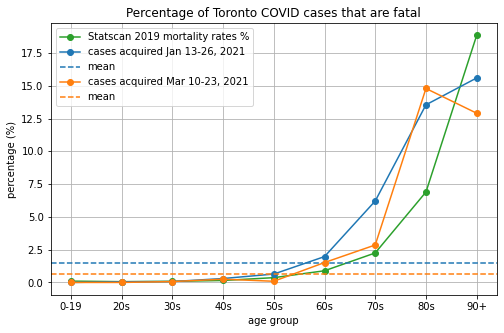

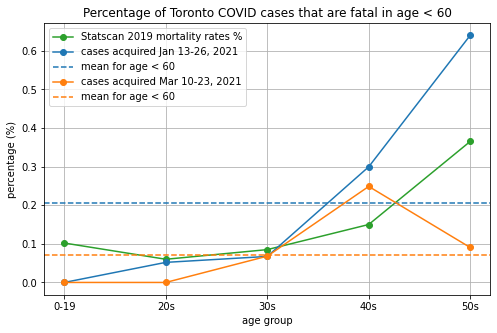

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(mort_pct_rates, marker='o', label='Statscan 2019 mortality rates %', color='tab:green')
plt.plot(jan_by_age.pct_fatal, marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
plt.axhline(100*jan_by_age.sum().fatal/jan_by_age.sum().num_cases, color='tab:blue', linestyle='--', 
            label='mean')
plt.plot(mar_by_age.pct_fatal, marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
plt.axhline(100*mar_by_age.sum().fatal/mar_by_age.sum().num_cases, color='tab:orange', linestyle='--', 
            label='mean')
plt.title('Percentage of Toronto COVID cases that are fatal')
plt.xlabel('age group')
plt.ylabel('percentage (%)')
plt.grid()
plt.legend()
plt.show();

plt.figure(figsize=(8,5))
plt.plot(mort_pct_rates.loc[age_bands[0:5]], marker='o', label='Statscan 2019 mortality rates %', color='tab:green')
plt.plot(jan_by_age_under60.pct_fatal, marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
plt.axhline(y=100*jan_by_age_under60.fatal.sum()/jan_by_age_under60.num_cases.sum(), 
            color='tab:blue', linestyle='--', label='mean for age < 60')
plt.plot(mar_by_age_under60.pct_fatal, marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
plt.axhline(y=100*mar_by_age_under60.fatal.sum()/mar_by_age_under60.num_cases.sum(), 
            color='tab:orange', linestyle='--', label='mean for age < 60')
plt.title('Percentage of Toronto COVID cases that are fatal in age < 60')
plt.xlabel('age group')
plt.ylabel('percentage (%)')
plt.grid()
plt.legend()
plt.show();

# Hospitalized, ICU and Intubated Cases

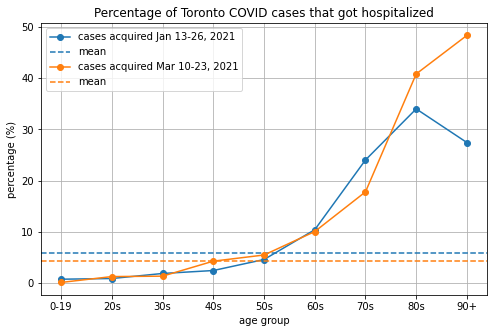

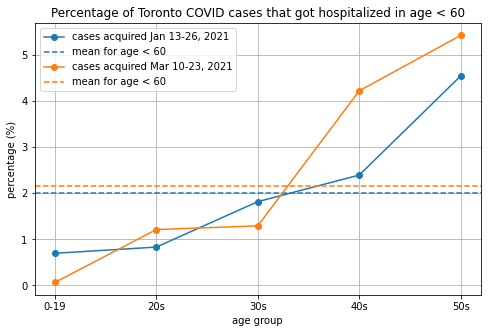

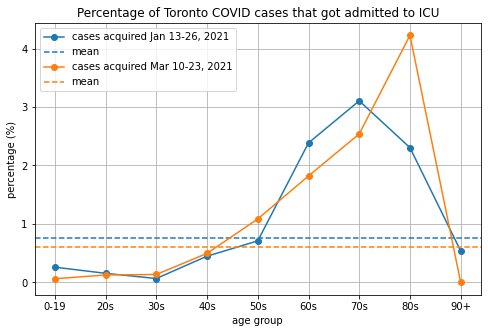

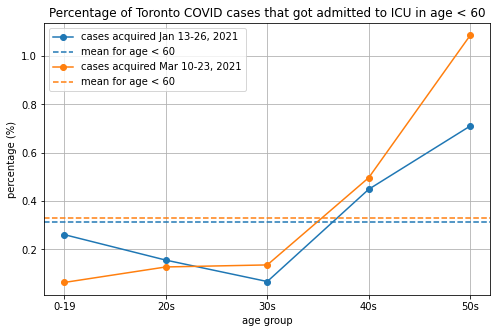

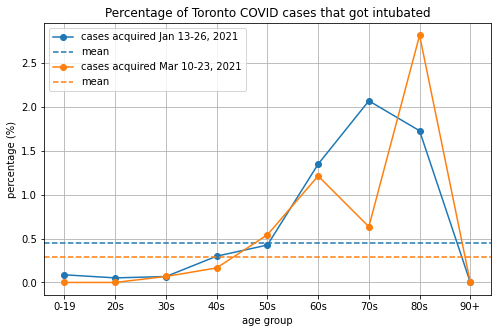

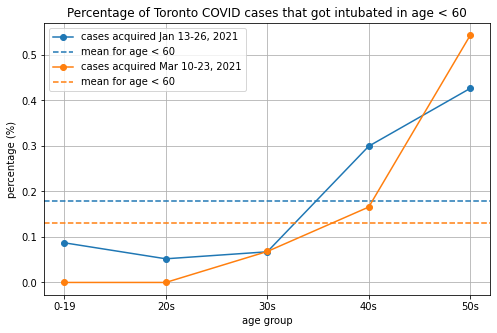

In [19]:
for outcome_type in outcome_list[1:]:  
  outcome_descriptions = {'ever_hosp':'hospitalized', 'ever_icu':'admitted to ICU', 'ever_intub':'intubated'}
  plt.figure(figsize=(8,5))
  plt.plot(jan_by_age['pct_'+outcome_type], marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
  plt.axhline(100*jan_by_age[outcome_type].sum()/jan_by_age.num_cases.sum(), color='tab:blue', linestyle='--', 
              label='mean')
  plt.plot(mar_by_age['pct_'+outcome_type], marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
  plt.axhline(100*mar_by_age[outcome_type].sum()/mar_by_age.num_cases.sum(), color='tab:orange', linestyle='--', 
              label='mean')
  plt.title('Percentage of Toronto COVID cases that got {}'.format(outcome_descriptions[outcome_type]))
  plt.xlabel('age group')
  plt.ylabel('percentage (%)')
  plt.grid()
  plt.legend()
  plt.show();

  plt.figure(figsize=(8,5))
  plt.plot(jan_by_age_under60['pct_'+outcome_type], marker='o', label='cases acquired '+jan_date_range_str, color='tab:blue')
  plt.axhline(y=100*jan_by_age_under60[outcome_type].sum()/jan_by_age_under60.num_cases.sum(), 
              color='tab:blue', linestyle='--', label='mean for age < 60')
  plt.plot(mar_by_age_under60['pct_'+outcome_type], marker='o', label='cases acquired '+mar_date_range_str, color='tab:orange')
  plt.axhline(y=100*mar_by_age_under60[outcome_type].sum()/mar_by_age_under60.num_cases.sum(), 
              color='tab:orange', linestyle='--', label='mean for age < 60')
  plt.title('Percentage of Toronto COVID cases that got {} in age < 60'.format(outcome_descriptions[outcome_type]))
  plt.xlabel('age group')
  plt.ylabel('percentage (%)')
  plt.grid()
  plt.legend()
  plt.show();